In [1]:
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [51]:
df = pd.read_csv("../raw_data/df_energy_weather.csv", index_col=[0])
df = df.rename(columns={"Consommation (MW)": "conso"})

In [52]:
df.columns

Index(['Date', 'Code INSEE région', 'conso', 'Thermique (MW)',
       'Nucléaire (MW)', 'Eolien (MW)', 'Solaire (MW)', 'Hydraulique (MW)',
       'Pompage (MW)', 'Bioénergies (MW)', 'Ech. physiques (MW)',
       'Stockage batterie', 'Déstockage batterie', 'Eolien terrestre',
       'Eolien offshore', 'TCO Thermique (%)', 'TCH Thermique (%)',
       'TCO Nucléaire (%)', 'TCH Nucléaire (%)', 'TCO Eolien (%)',
       'TCH Eolien (%)', 'TCO Solaire (%)', 'TCH Solaire (%)', 'Column 30',
       'YEAR', 'MONTH', 'DAY', 'T2M', 'T2MDEW', 'T2MWET', 'TS', 'T2M_RANGE',
       'T2M_MAX', 'T2M_MIN', 'QV2M', 'RH2M', 'PRECTOTCORR', 'PS', 'WS10M',
       'WS50M'],
      dtype='object')

In [53]:
#df = df[['Consommation (MW)','T2M', 'T2MDEW', 'T2MWET', 'TS', 'T2M_RANGE','T2M_MAX', 'T2M_MIN', 'QV2M', 'RH2M', 'PRECTOTCORR', 'PS', 'WS10M','WS50M']]

In [55]:
df = df[['conso','T2M']]

In [56]:
df

,conso,T2M
0,257058.278726,7.30
1,280064.000000,4.36
2,285526.000000,5.46
3,286799.000000,5.92
4,267848.000000,6.64
...,...,...
3412,218296.000000,18.10
3413,209770.000000,18.13
3414,201061.000000,18.01
3415,194195.000000,19.47


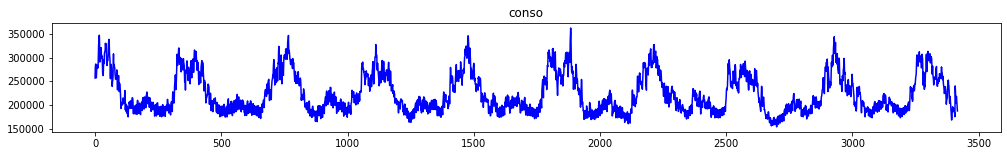

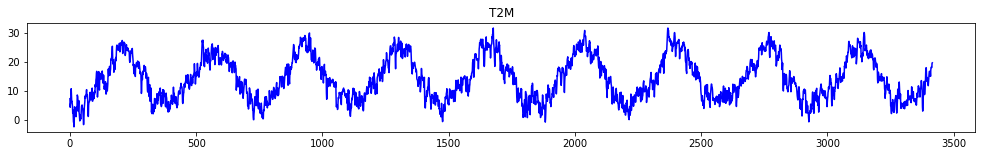

In [57]:
for col in df.columns:
    color="orange" if col == "pm2.5" else "blue"
    df[col].plot(figsize=(17, 2), color=color)
    plt.title(col)
    plt.show()

In [58]:
df.describe()

,conso,T2M
count,3417.000000,3417.000000
mean,224989.378858,14.253202
std,39697.681331,7.311808
min,153691.000000,-2.380000
25%,194272.000000,8.190000
50%,210106.000000,13.560000
75%,254321.000000,20.300000
max,362960.000000,31.590000


## Création des sequences X & y

In [59]:


def subsample_sequence(df, length):

    # $CHALLENGIFY_BEGIN
    last_possible = df.shape[0] - length
    
    random_start = np.random.randint(0, last_possible)
    df_sample = df[random_start: random_start+length]
    # $CHALLENGIFY_END
    return df_sample

In [60]:
# pourquoi pas:
# def split_subsample_sequence(df, length, "ecart", "lenght_y")
# df_subsample.iloc[length - "ecart" -  "lenght_y"]
# X_sample = df_subsample[0:length -"ecart" - "lenght_y"]


In [63]:
def split_subsample_sequence(df, length):
    '''Create one single random (X,y) pair'''
    # $CHALLENGIFY_BEGIN
    df_subsample = subsample_sequence(df, length)
    y_sample = df_subsample.iloc[length -1]['conso']
    
    X_sample = df_subsample[0:length -1]
    X_sample = X_sample.values
    # $CHALLENGIFY_END
    return np.array(X_sample), np.array(y_sample)

## Création de plusieurs sequences X & y

In [64]:
# pourquoi pas:
# def get_X_y(df, n_sequences, length, "ecart", , "lenght_y")
# (xi, yi) = split_subsample_sequence(df, length,"ecart" , "lenght_y")

In [65]:
def get_X_y(df, n_sequences, length):
    '''Return a list of samples (X, y)'''
    # $CHALLENGIFY_BEGIN
    X, y = [], []

    for i in range(n_sequences):
        (xi, yi) = split_subsample_sequence(df, length)
        X.append(xi)
        y.append(yi)
        
    X = np.array(X)
    y = np.array(y)
    # $CHALLENGIFY_END
    return X, y

In [66]:
X, y = get_X_y(df, 200, 21)
print(X.shape)
print(y.shape)

(200, 20, 2)
(200,)


In [67]:
#X[0]

# copie des trois fonction + ajout des écarts longueur y

def split_subsample_sequence(df, length_x, ecart , length_y ):
    '''Create one single random (X,y) pair'''
    # $CHALLENGIFY_BEGIN
    length = length_x + ecart + length_y
    df_subsample = subsample_sequence(df, length)
    y_sample = df_subsample.iloc[length_x + ecart:length]['Consommation (MW)']
    
    X_sample = df_subsample[0:length_x]
    X_sample = X_sample.values
    # $CHALLENGIFY_END
    return np.array(X_sample), np.array(y_sample)

def get_X_y(df, n_sequences, length_x, ecart , length_y):
    '''Return a list of samples (X, y)'''
    # $CHALLENGIFY_BEGIN
    
    
    X, y = [], []

    for i in range(n_sequences):
        (xi, yi) = split_subsample_sequence(df, length_x, ecart , length_y)
        X.append(xi)
        y.append(yi)
        
    X = np.array(X)
    y = np.array(y)
    # $CHALLENGIFY_END
    return X, y

In [68]:
#X, y = get_X_y(df, 200, 25,5,5)
#print(X.shape)
#print(y.shape)

In [69]:
len_ = int(0.8*df.shape[0])
df_train = df[:len_]
df_test = df[len_:]

In [70]:
X_train, y_train = get_X_y(df_train, 200, 21)
X_test, y_test = get_X_y(df_test, 40, 21)

In [71]:
# FONCTION POUR RECREER TRAIN & TEST


def creation_trains_tests(df, n_sequences, length_x, ecart, length_y, pourcent_test):
    len_ = int(pourcent_test*df.shape[0])
    df_train = df[:len_]
    df_test = df[len_:]
    X_train, y_train = get_X_y(df_train, n_sequences, length_x, ecart, length_y)
    X_test, y_test = get_X_y(df_test, n_sequences, length_x, ecart, length_y)
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)
    return X_train, y_train, X_test, y_test

# df = dataframe
# n_sequences = nombre de séquence de l'échantillon 
# length_x = longueur de la séquence X
# ecart = ecart entre la sequence X et la sequence Y
# length_y = longueur de la séquence Y

n_sequences = 200
length_x = 40
ecart = 0
length_y = 1
pourcent_test = 0.7

In [72]:
#creation_trains_tests(df, n_sequences, length_x, ecart, length_y, pourcent_test)

In [73]:
#array = creation_trains_tests(df, n_sequences, length_x, ecart, length_y, pourcent_test)

In [74]:
#X_train = array[0]
#X_train.shape

In [75]:
#y_train = array[1]
#y_train.shape

In [76]:
#X_test = array[2]
#X_test.shape

In [77]:
#y_test = array[3]
#y_test.shape

In [78]:
#print(X_train.shape)
#print(y_train.shape)
#print(X_test.shape)
#print(y_test.shape)

In [79]:
#X_train[0][0]

In [80]:
#y_train[0]

X_train, y_train, X_test, y_test = creation_trains_tests(df, n_sequences, length_x, ecart, length_y, pourcent_test)

In [81]:
X_train.shape

(200, 20, 2)

In [82]:
y_pred = np.mean(y_train)
bench_res = np.mean(np.abs(y_pred - y_test)/y_test)*100

print(f'Benchmark MAPE on the test set : {bench_res:.0f} %')

Benchmark MAPE on the test set : 13 %


In [83]:
#y_pred_baseline = X_test[:,-1,0]
#bench_res = np.mean(np.abs(y_pred_baseline - y_test)/y_test)*100
#print(f'Benchmark MAPE on the test set : {bench_res:.0f} %')

# Simple LSTM

In [84]:
# Revoir la liste des imports nécessaires
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers.experimental.preprocessing import Normalization

In [85]:
def init_model():
    metric = metrics.MAPE
    opt = optimizers.RMSprop(learning_rate=0.01)
    
    normalizer = Normalization()
    normalizer.adapt(X_train)

    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(loss='mse', 
                  optimizer=opt, 
                  metrics=[metric])
    
    return model

In [86]:
model = init_model()
#model.summary()

In [87]:
from tensorflow.keras.callbacks import EarlyStopping

In [88]:
es = EarlyStopping(monitor='val_loss', verbose=1, patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
            validation_split=0.2,
            epochs=1000, 
            batch_size=64,
            callbacks=[es], verbose=1)

Epoch 1/1000
3/3 [==============================] - 1s 106ms/step - loss: 54436999168.0000 - mean_absolute_percentage_error: 99.9999 - val_loss: 50828333056.0000 - val_mean_absolute_percentage_error: 99.9990
Epoch 2/1000
3/3 [==============================] - 0s 11ms/step - loss: 54435368960.0000 - mean_absolute_percentage_error: 99.9984 - val_loss: 50825699328.0000 - val_mean_absolute_percentage_error: 99.9961
Epoch 3/1000
3/3 [==============================] - 0s 10ms/step - loss: 54432751616.0000 - mean_absolute_percentage_error: 99.9957 - val_loss: 50823921664.0000 - val_mean_absolute_percentage_error: 99.9942
Epoch 4/1000
3/3 [==============================] - 0s 10ms/step - loss: 54431035392.0000 - mean_absolute_percentage_error: 99.9940 - val_loss: 50822512640.0000 - val_mean_absolute_percentage_error: 99.9928
Epoch 5/1000
3/3 [==============================] - 0s 10ms/step - loss: 54429638656.0000 - mean_absolute_percentage_error: 99.9926 - val_loss: 50821263360.0000 - val_mean

3/3 [==============================] - 0s 9ms/step - loss: 54370856960.0000 - mean_absolute_percentage_error: 99.9349 - val_loss: 50763694080.0000 - val_mean_absolute_percentage_error: 99.9312
Epoch 41/1000
3/3 [==============================] - 0s 9ms/step - loss: 54368546816.0000 - mean_absolute_percentage_error: 99.9326 - val_loss: 50761408512.0000 - val_mean_absolute_percentage_error: 99.9288
Epoch 42/1000
3/3 [==============================] - 0s 9ms/step - loss: 54366171136.0000 - mean_absolute_percentage_error: 99.9303 - val_loss: 50759081984.0000 - val_mean_absolute_percentage_error: 99.9264
Epoch 43/1000
3/3 [==============================] - 0s 9ms/step - loss: 54363770880.0000 - mean_absolute_percentage_error: 99.9279 - val_loss: 50756771840.0000 - val_mean_absolute_percentage_error: 99.9240
Epoch 44/1000
3/3 [==============================] - 0s 9ms/step - loss: 54361362432.0000 - mean_absolute_percentage_error: 99.9256 - val_loss: 50754400256.0000 - val_mean_absolute_perce

Epoch 80/1000
3/3 [==============================] - 0s 9ms/step - loss: 54250123264.0000 - mean_absolute_percentage_error: 99.8162 - val_loss: 50645917696.0000 - val_mean_absolute_percentage_error: 99.8078
Epoch 81/1000
3/3 [==============================] - 0s 9ms/step - loss: 54246375424.0000 - mean_absolute_percentage_error: 99.8125 - val_loss: 50642255872.0000 - val_mean_absolute_percentage_error: 99.8040
Epoch 82/1000
3/3 [==============================] - 0s 9ms/step - loss: 54242594816.0000 - mean_absolute_percentage_error: 99.8088 - val_loss: 50638602240.0000 - val_mean_absolute_percentage_error: 99.8002
Epoch 83/1000
3/3 [==============================] - 0s 9ms/step - loss: 54238797824.0000 - mean_absolute_percentage_error: 99.8051 - val_loss: 50634891264.0000 - val_mean_absolute_percentage_error: 99.7963
Epoch 84/1000
3/3 [==============================] - 0s 9ms/step - loss: 54234947584.0000 - mean_absolute_percentage_error: 99.8013 - val_loss: 50631122944.0000 - val_mean_

3/3 [==============================] - 0s 9ms/step - loss: 54077689856.0000 - mean_absolute_percentage_error: 99.6465 - val_loss: 50478206976.0000 - val_mean_absolute_percentage_error: 99.6320
Epoch 120/1000
3/3 [==============================] - 0s 9ms/step - loss: 54072582144.0000 - mean_absolute_percentage_error: 99.6415 - val_loss: 50473226240.0000 - val_mean_absolute_percentage_error: 99.6267
Epoch 121/1000
3/3 [==============================] - 0s 9ms/step - loss: 54067425280.0000 - mean_absolute_percentage_error: 99.6364 - val_loss: 50468200448.0000 - val_mean_absolute_percentage_error: 99.6215
Epoch 122/1000
3/3 [==============================] - 0s 9ms/step - loss: 54062231552.0000 - mean_absolute_percentage_error: 99.6313 - val_loss: 50463199232.0000 - val_mean_absolute_percentage_error: 99.6162
Epoch 123/1000
3/3 [==============================] - 0s 9ms/step - loss: 54057029632.0000 - mean_absolute_percentage_error: 99.6262 - val_loss: 50458095616.0000 - val_mean_absolute_p

3/3 [==============================] - 0s 9ms/step - loss: 53852069888.0000 - mean_absolute_percentage_error: 99.4241 - val_loss: 50259046400.0000 - val_mean_absolute_percentage_error: 99.4016
Epoch 159/1000
3/3 [==============================] - 0s 9ms/step - loss: 53845590016.0000 - mean_absolute_percentage_error: 99.4176 - val_loss: 50252816384.0000 - val_mean_absolute_percentage_error: 99.3951
Epoch 160/1000
3/3 [==============================] - 0s 9ms/step - loss: 53839122432.0000 - mean_absolute_percentage_error: 99.4113 - val_loss: 50246496256.0000 - val_mean_absolute_percentage_error: 99.3884
Epoch 161/1000
3/3 [==============================] - 0s 9ms/step - loss: 53832572928.0000 - mean_absolute_percentage_error: 99.4048 - val_loss: 50240122880.0000 - val_mean_absolute_percentage_error: 99.3817
Epoch 162/1000
3/3 [==============================] - 0s 13ms/step - loss: 53825970176.0000 - mean_absolute_percentage_error: 99.3983 - val_loss: 50233724928.0000 - val_mean_absolute_

3/3 [==============================] - 0s 9ms/step - loss: 53573775360.0000 - mean_absolute_percentage_error: 99.1490 - val_loss: 49989017600.0000 - val_mean_absolute_percentage_error: 99.1172
Epoch 198/1000
3/3 [==============================] - 0s 9ms/step - loss: 53565972480.0000 - mean_absolute_percentage_error: 99.1412 - val_loss: 49981534208.0000 - val_mean_absolute_percentage_error: 99.1093
Epoch 199/1000
3/3 [==============================] - 0s 9ms/step - loss: 53558190080.0000 - mean_absolute_percentage_error: 99.1335 - val_loss: 49973927936.0000 - val_mean_absolute_percentage_error: 99.1012
Epoch 200/1000
3/3 [==============================] - 0s 9ms/step - loss: 53550321664.0000 - mean_absolute_percentage_error: 99.1257 - val_loss: 49966325760.0000 - val_mean_absolute_percentage_error: 99.0932
Epoch 201/1000
3/3 [==============================] - 0s 9ms/step - loss: 53542428672.0000 - mean_absolute_percentage_error: 99.1180 - val_loss: 49958600704.0000 - val_mean_absolute_p

3/3 [==============================] - 0s 9ms/step - loss: 53243412480.0000 - mean_absolute_percentage_error: 98.8215 - val_loss: 49668710400.0000 - val_mean_absolute_percentage_error: 98.7787
Epoch 237/1000
3/3 [==============================] - 0s 9ms/step - loss: 53234262016.0000 - mean_absolute_percentage_error: 98.8125 - val_loss: 49659813888.0000 - val_mean_absolute_percentage_error: 98.7693
Epoch 238/1000
3/3 [==============================] - 0s 9ms/step - loss: 53225070592.0000 - mean_absolute_percentage_error: 98.8032 - val_loss: 49650954240.0000 - val_mean_absolute_percentage_error: 98.7599
Epoch 239/1000
3/3 [==============================] - 0s 10ms/step - loss: 53215887360.0000 - mean_absolute_percentage_error: 98.7942 - val_loss: 49642020864.0000 - val_mean_absolute_percentage_error: 98.7504
Epoch 240/1000
3/3 [==============================] - 0s 9ms/step - loss: 53206646784.0000 - mean_absolute_percentage_error: 98.7849 - val_loss: 49633095680.0000 - val_mean_absolute_

3/3 [==============================] - 0s 9ms/step - loss: 52861644800.0000 - mean_absolute_percentage_error: 98.4418 - val_loss: 49298788352.0000 - val_mean_absolute_percentage_error: 98.3864
Epoch 276/1000
3/3 [==============================] - 0s 9ms/step - loss: 52851228672.0000 - mean_absolute_percentage_error: 98.4314 - val_loss: 49288605696.0000 - val_mean_absolute_percentage_error: 98.3755
Epoch 277/1000
3/3 [==============================] - 0s 10ms/step - loss: 52840685568.0000 - mean_absolute_percentage_error: 98.4209 - val_loss: 49278365696.0000 - val_mean_absolute_percentage_error: 98.3646
Epoch 278/1000
3/3 [==============================] - 0s 9ms/step - loss: 52830121984.0000 - mean_absolute_percentage_error: 98.4103 - val_loss: 49268269056.0000 - val_mean_absolute_percentage_error: 98.3539
Epoch 279/1000
3/3 [==============================] - 0s 9ms/step - loss: 52819644416.0000 - mean_absolute_percentage_error: 98.3999 - val_loss: 49258029056.0000 - val_mean_absolute_

3/3 [==============================] - 0s 9ms/step - loss: 52429090816.0000 - mean_absolute_percentage_error: 98.0098 - val_loss: 48879755264.0000 - val_mean_absolute_percentage_error: 97.9401
Epoch 315/1000
3/3 [==============================] - 0s 9ms/step - loss: 52417372160.0000 - mean_absolute_percentage_error: 97.9979 - val_loss: 48868429824.0000 - val_mean_absolute_percentage_error: 97.9280
Epoch 316/1000
3/3 [==============================] - 0s 9ms/step - loss: 52405637120.0000 - mean_absolute_percentage_error: 97.9862 - val_loss: 48857047040.0000 - val_mean_absolute_percentage_error: 97.9159
Epoch 317/1000
3/3 [==============================] - 0s 9ms/step - loss: 52393844736.0000 - mean_absolute_percentage_error: 97.9744 - val_loss: 48845631488.0000 - val_mean_absolute_percentage_error: 97.9037
Epoch 318/1000
3/3 [==============================] - 0s 9ms/step - loss: 52381999104.0000 - mean_absolute_percentage_error: 97.9626 - val_loss: 48834072576.0000 - val_mean_absolute_p

3/3 [==============================] - 0s 9ms/step - loss: 51946672128.0000 - mean_absolute_percentage_error: 97.5256 - val_loss: 48412745728.0000 - val_mean_absolute_percentage_error: 97.4404
Epoch 354/1000
3/3 [==============================] - 0s 9ms/step - loss: 51933741056.0000 - mean_absolute_percentage_error: 97.5127 - val_loss: 48400044032.0000 - val_mean_absolute_percentage_error: 97.4268
Epoch 355/1000
3/3 [==============================] - 0s 9ms/step - loss: 51920601088.0000 - mean_absolute_percentage_error: 97.4995 - val_loss: 48387371008.0000 - val_mean_absolute_percentage_error: 97.4132
Epoch 356/1000
3/3 [==============================] - 0s 9ms/step - loss: 51907502080.0000 - mean_absolute_percentage_error: 97.4862 - val_loss: 48374755328.0000 - val_mean_absolute_percentage_error: 97.3997
Epoch 357/1000
3/3 [==============================] - 0s 9ms/step - loss: 51894444032.0000 - mean_absolute_percentage_error: 97.4730 - val_loss: 48362151936.0000 - val_mean_absolute_p

3/3 [==============================] - 0s 9ms/step - loss: 51414970368.0000 - mean_absolute_percentage_error: 96.9896 - val_loss: 47897980928.0000 - val_mean_absolute_percentage_error: 96.8867
Epoch 393/1000
3/3 [==============================] - 0s 10ms/step - loss: 51400663040.0000 - mean_absolute_percentage_error: 96.9750 - val_loss: 47884189696.0000 - val_mean_absolute_percentage_error: 96.8719
Epoch 394/1000
3/3 [==============================] - 0s 9ms/step - loss: 51386343424.0000 - mean_absolute_percentage_error: 96.9607 - val_loss: 47870234624.0000 - val_mean_absolute_percentage_error: 96.8568
Epoch 395/1000
3/3 [==============================] - 0s 9ms/step - loss: 51371921408.0000 - mean_absolute_percentage_error: 96.9460 - val_loss: 47856365568.0000 - val_mean_absolute_percentage_error: 96.8419
Epoch 396/1000
3/3 [==============================] - 0s 9ms/step - loss: 51357552640.0000 - mean_absolute_percentage_error: 96.9316 - val_loss: 47842447360.0000 - val_mean_absolute_

3/3 [==============================] - 0s 11ms/step - loss: 50834710528.0000 - mean_absolute_percentage_error: 96.4010 - val_loss: 47336644608.0000 - val_mean_absolute_percentage_error: 96.2795
Epoch 432/1000
3/3 [==============================] - 0s 8ms/step - loss: 50819244032.0000 - mean_absolute_percentage_error: 96.3853 - val_loss: 47321600000.0000 - val_mean_absolute_percentage_error: 96.2631
Epoch 433/1000
3/3 [==============================] - 0s 8ms/step - loss: 50803662848.0000 - mean_absolute_percentage_error: 96.3696 - val_loss: 47306559488.0000 - val_mean_absolute_percentage_error: 96.2468
Epoch 434/1000
3/3 [==============================] - 0s 8ms/step - loss: 50788085760.0000 - mean_absolute_percentage_error: 96.3537 - val_loss: 47291502592.0000 - val_mean_absolute_percentage_error: 96.2305
Epoch 435/1000
3/3 [==============================] - 0s 9ms/step - loss: 50772492288.0000 - mean_absolute_percentage_error: 96.3378 - val_loss: 47276412928.0000 - val_mean_absolute_

3/3 [==============================] - 0s 8ms/step - loss: 50207465472.0000 - mean_absolute_percentage_error: 95.7609 - val_loss: 46730010624.0000 - val_mean_absolute_percentage_error: 95.6190
Epoch 471/1000
3/3 [==============================] - 0s 8ms/step - loss: 50190790656.0000 - mean_absolute_percentage_error: 95.7441 - val_loss: 46713761792.0000 - val_mean_absolute_percentage_error: 95.6012
Epoch 472/1000
3/3 [==============================] - 0s 8ms/step - loss: 50173976576.0000 - mean_absolute_percentage_error: 95.7268 - val_loss: 46697553920.0000 - val_mean_absolute_percentage_error: 95.5835
Epoch 473/1000
3/3 [==============================] - 0s 8ms/step - loss: 50157150208.0000 - mean_absolute_percentage_error: 95.7097 - val_loss: 46681202688.0000 - val_mean_absolute_percentage_error: 95.5656
Epoch 474/1000
3/3 [==============================] - 0s 8ms/step - loss: 50140225536.0000 - mean_absolute_percentage_error: 95.6923 - val_loss: 46664855552.0000 - val_mean_absolute_p

3/3 [==============================] - 0s 9ms/step - loss: 49533399040.0000 - mean_absolute_percentage_error: 95.0688 - val_loss: 46078136320.0000 - val_mean_absolute_percentage_error: 94.9042
Epoch 510/1000
3/3 [==============================] - 0s 9ms/step - loss: 49515421696.0000 - mean_absolute_percentage_error: 95.0499 - val_loss: 46060920832.0000 - val_mean_absolute_percentage_error: 94.8853
Epoch 511/1000
3/3 [==============================] - 0s 9ms/step - loss: 49497518080.0000 - mean_absolute_percentage_error: 95.0319 - val_loss: 46043488256.0000 - val_mean_absolute_percentage_error: 94.8661
Epoch 512/1000
3/3 [==============================] - 0s 9ms/step - loss: 49479520256.0000 - mean_absolute_percentage_error: 95.0130 - val_loss: 46026248192.0000 - val_mean_absolute_percentage_error: 94.8471
Epoch 513/1000
3/3 [==============================] - 0s 9ms/step - loss: 49461637120.0000 - mean_absolute_percentage_error: 94.9947 - val_loss: 46008954880.0000 - val_mean_absolute_p

3/3 [==============================] - 0s 9ms/step - loss: 48813879296.0000 - mean_absolute_percentage_error: 94.3242 - val_loss: 45382991872.0000 - val_mean_absolute_percentage_error: 94.1363
Epoch 549/1000
3/3 [==============================] - 0s 9ms/step - loss: 48794939392.0000 - mean_absolute_percentage_error: 94.3048 - val_loss: 45364502528.0000 - val_mean_absolute_percentage_error: 94.1158
Epoch 550/1000
3/3 [==============================] - 0s 9ms/step - loss: 48775790592.0000 - mean_absolute_percentage_error: 94.2849 - val_loss: 45346025472.0000 - val_mean_absolute_percentage_error: 94.0953
Epoch 551/1000
3/3 [==============================] - 0s 9ms/step - loss: 48756633600.0000 - mean_absolute_percentage_error: 94.2650 - val_loss: 45327519744.0000 - val_mean_absolute_percentage_error: 94.0747
Epoch 552/1000
3/3 [==============================] - 0s 9ms/step - loss: 48737550336.0000 - mean_absolute_percentage_error: 94.2447 - val_loss: 45309353984.0000 - val_mean_absolute_p

3/3 [==============================] - 0s 9ms/step - loss: 48050896896.0000 - mean_absolute_percentage_error: 93.5284 - val_loss: 44645822464.0000 - val_mean_absolute_percentage_error: 93.3152
Epoch 588/1000
3/3 [==============================] - 0s 9ms/step - loss: 48030797824.0000 - mean_absolute_percentage_error: 93.5075 - val_loss: 44626345984.0000 - val_mean_absolute_percentage_error: 93.2934
Epoch 589/1000
3/3 [==============================] - 0s 9ms/step - loss: 48010596352.0000 - mean_absolute_percentage_error: 93.4863 - val_loss: 44606808064.0000 - val_mean_absolute_percentage_error: 93.2715
Epoch 590/1000
3/3 [==============================] - 0s 9ms/step - loss: 47990317056.0000 - mean_absolute_percentage_error: 93.4652 - val_loss: 44587180032.0000 - val_mean_absolute_percentage_error: 93.2496
Epoch 591/1000
3/3 [==============================] - 0s 9ms/step - loss: 47969984512.0000 - mean_absolute_percentage_error: 93.4438 - val_loss: 44567588864.0000 - val_mean_absolute_p

3/3 [==============================] - 0s 9ms/step - loss: 47244464128.0000 - mean_absolute_percentage_error: 92.6800 - val_loss: 43867185152.0000 - val_mean_absolute_percentage_error: 92.4402
Epoch 627/1000
3/3 [==============================] - 0s 9ms/step - loss: 47223341056.0000 - mean_absolute_percentage_error: 92.6583 - val_loss: 43846348800.0000 - val_mean_absolute_percentage_error: 92.4167
Epoch 628/1000
3/3 [==============================] - 0s 8ms/step - loss: 47201820672.0000 - mean_absolute_percentage_error: 92.6353 - val_loss: 43825803264.0000 - val_mean_absolute_percentage_error: 92.3935
Epoch 629/1000
3/3 [==============================] - 0s 9ms/step - loss: 47180537856.0000 - mean_absolute_percentage_error: 92.6127 - val_loss: 43805351936.0000 - val_mean_absolute_percentage_error: 92.3704
Epoch 630/1000
3/3 [==============================] - 0s 9ms/step - loss: 47159320576.0000 - mean_absolute_percentage_error: 92.5902 - val_loss: 43784806400.0000 - val_mean_absolute_p

3/3 [==============================] - 0s 9ms/step - loss: 46396801024.0000 - mean_absolute_percentage_error: 91.7803 - val_loss: 43048861696.0000 - val_mean_absolute_percentage_error: 91.5119
Epoch 666/1000
3/3 [==============================] - 0s 9ms/step - loss: 46374608896.0000 - mean_absolute_percentage_error: 91.7569 - val_loss: 43027259392.0000 - val_mean_absolute_percentage_error: 91.4873
Epoch 667/1000
3/3 [==============================] - 0s 9ms/step - loss: 46352257024.0000 - mean_absolute_percentage_error: 91.7327 - val_loss: 43005796352.0000 - val_mean_absolute_percentage_error: 91.4628
Epoch 668/1000
3/3 [==============================] - 0s 9ms/step - loss: 46329933824.0000 - mean_absolute_percentage_error: 91.7093 - val_loss: 42984120320.0000 - val_mean_absolute_percentage_error: 91.4381
Epoch 669/1000
3/3 [==============================] - 0s 8ms/step - loss: 46307500032.0000 - mean_absolute_percentage_error: 91.6852 - val_loss: 42962649088.0000 - val_mean_absolute_p

3/3 [==============================] - 0s 9ms/step - loss: 45508517888.0000 - mean_absolute_percentage_error: 90.8285 - val_loss: 42191683584.0000 - val_mean_absolute_percentage_error: 90.5297
Epoch 705/1000
3/3 [==============================] - 0s 9ms/step - loss: 45485252608.0000 - mean_absolute_percentage_error: 90.8036 - val_loss: 42169233408.0000 - val_mean_absolute_percentage_error: 90.5038
Epoch 706/1000
3/3 [==============================] - 0s 9ms/step - loss: 45461987328.0000 - mean_absolute_percentage_error: 90.7781 - val_loss: 42146779136.0000 - val_mean_absolute_percentage_error: 90.4780
Epoch 707/1000
3/3 [==============================] - 0s 9ms/step - loss: 45438656512.0000 - mean_absolute_percentage_error: 90.7534 - val_loss: 42124271616.0000 - val_mean_absolute_percentage_error: 90.4520
Epoch 708/1000
3/3 [==============================] - 0s 9ms/step - loss: 45415325696.0000 - mean_absolute_percentage_error: 90.7279 - val_loss: 42101825536.0000 - val_mean_absolute_p

3/3 [==============================] - 0s 9ms/step - loss: 44582445056.0000 - mean_absolute_percentage_error: 89.8252 - val_loss: 41298657280.0000 - val_mean_absolute_percentage_error: 89.4953
Epoch 744/1000
3/3 [==============================] - 0s 9ms/step - loss: 44558307328.0000 - mean_absolute_percentage_error: 89.7991 - val_loss: 41275166720.0000 - val_mean_absolute_percentage_error: 89.4679
Epoch 745/1000
3/3 [==============================] - 0s 9ms/step - loss: 44533927936.0000 - mean_absolute_percentage_error: 89.7727 - val_loss: 41251692544.0000 - val_mean_absolute_percentage_error: 89.4406
Epoch 746/1000
3/3 [==============================] - 0s 9ms/step - loss: 44509560832.0000 - mean_absolute_percentage_error: 89.7461 - val_loss: 41228197888.0000 - val_mean_absolute_percentage_error: 89.4132
Epoch 747/1000
3/3 [==============================] - 0s 9ms/step - loss: 44485189632.0000 - mean_absolute_percentage_error: 89.7193 - val_loss: 41204686848.0000 - val_mean_absolute_p

3/3 [==============================] - 0s 9ms/step - loss: 43618349056.0000 - mean_absolute_percentage_error: 88.7698 - val_loss: 40369180672.0000 - val_mean_absolute_percentage_error: 88.4062
Epoch 783/1000
3/3 [==============================] - 0s 9ms/step - loss: 43593195520.0000 - mean_absolute_percentage_error: 88.7420 - val_loss: 40344866816.0000 - val_mean_absolute_percentage_error: 88.3775
Epoch 784/1000
3/3 [==============================] - 0s 9ms/step - loss: 43567960064.0000 - mean_absolute_percentage_error: 88.7143 - val_loss: 40320651264.0000 - val_mean_absolute_percentage_error: 88.3490
Epoch 785/1000
3/3 [==============================] - 0s 9ms/step - loss: 43542847488.0000 - mean_absolute_percentage_error: 88.6862 - val_loss: 40296488960.0000 - val_mean_absolute_percentage_error: 88.3205
Epoch 786/1000
3/3 [==============================] - 0s 8ms/step - loss: 43517718528.0000 - mean_absolute_percentage_error: 88.6585 - val_loss: 40272171008.0000 - val_mean_absolute_p

3/3 [==============================] - 0s 9ms/step - loss: 42618617856.0000 - mean_absolute_percentage_error: 87.6619 - val_loss: 39406075904.0000 - val_mean_absolute_percentage_error: 87.2638
Epoch 822/1000
3/3 [==============================] - 0s 9ms/step - loss: 42592722944.0000 - mean_absolute_percentage_error: 87.6333 - val_loss: 39380996096.0000 - val_mean_absolute_percentage_error: 87.2339
Epoch 823/1000
3/3 [==============================] - 0s 9ms/step - loss: 42566729728.0000 - mean_absolute_percentage_error: 87.6038 - val_loss: 39356071936.0000 - val_mean_absolute_percentage_error: 87.2041
Epoch 824/1000
3/3 [==============================] - 0s 8ms/step - loss: 42540748800.0000 - mean_absolute_percentage_error: 87.5753 - val_loss: 39330865152.0000 - val_mean_absolute_percentage_error: 87.1740
Epoch 825/1000
3/3 [==============================] - 0s 9ms/step - loss: 42514558976.0000 - mean_absolute_percentage_error: 87.5461 - val_loss: 39305641984.0000 - val_mean_absolute_p

3/3 [==============================] - 0s 9ms/step - loss: 41586380800.0000 - mean_absolute_percentage_error: 86.5037 - val_loss: 38411837440.0000 - val_mean_absolute_percentage_error: 86.0692
Epoch 861/1000
3/3 [==============================] - 0s 11ms/step - loss: 41559379968.0000 - mean_absolute_percentage_error: 86.4735 - val_loss: 38385795072.0000 - val_mean_absolute_percentage_error: 86.0377
Epoch 862/1000
3/3 [==============================] - 0s 11ms/step - loss: 41532370944.0000 - mean_absolute_percentage_error: 86.4428 - val_loss: 38359998464.0000 - val_mean_absolute_percentage_error: 86.0064
Epoch 863/1000
3/3 [==============================] - 0s 9ms/step - loss: 41505542144.0000 - mean_absolute_percentage_error: 86.4124 - val_loss: 38334128128.0000 - val_mean_absolute_percentage_error: 85.9751
Epoch 864/1000
3/3 [==============================] - 0s 9ms/step - loss: 41478606848.0000 - mean_absolute_percentage_error: 86.3822 - val_loss: 38308126720.0000 - val_mean_absolute

3/3 [==============================] - 0s 9ms/step - loss: 40521228288.0000 - mean_absolute_percentage_error: 85.2934 - val_loss: 37386657792.0000 - val_mean_absolute_percentage_error: 84.8203
Epoch 900/1000
3/3 [==============================] - 0s 9ms/step - loss: 40493449216.0000 - mean_absolute_percentage_error: 85.2612 - val_loss: 37360160768.0000 - val_mean_absolute_percentage_error: 84.7878
Epoch 901/1000
3/3 [==============================] - 0s 8ms/step - loss: 40465727488.0000 - mean_absolute_percentage_error: 85.2303 - val_loss: 37332979712.0000 - val_mean_absolute_percentage_error: 84.7544
Epoch 902/1000
3/3 [==============================] - 0s 9ms/step - loss: 40437620736.0000 - mean_absolute_percentage_error: 85.1975 - val_loss: 37306425344.0000 - val_mean_absolute_percentage_error: 84.7218
Epoch 903/1000
3/3 [==============================] - 0s 9ms/step - loss: 40410009600.0000 - mean_absolute_percentage_error: 85.1660 - val_loss: 37279911936.0000 - val_mean_absolute_p

3/3 [==============================] - 0s 9ms/step - loss: 39426957312.0000 - mean_absolute_percentage_error: 84.0315 - val_loss: 36334202880.0000 - val_mean_absolute_percentage_error: 83.5194
Epoch 939/1000
3/3 [==============================] - 0s 9ms/step - loss: 39398473728.0000 - mean_absolute_percentage_error: 83.9981 - val_loss: 36306857984.0000 - val_mean_absolute_percentage_error: 83.4854
Epoch 940/1000
3/3 [==============================] - 0s 9ms/step - loss: 39369994240.0000 - mean_absolute_percentage_error: 83.9654 - val_loss: 36279492608.0000 - val_mean_absolute_percentage_error: 83.4513
Epoch 941/1000
3/3 [==============================] - 0s 8ms/step - loss: 39341449216.0000 - mean_absolute_percentage_error: 83.9326 - val_loss: 36251869184.0000 - val_mean_absolute_percentage_error: 83.4168
Epoch 942/1000
3/3 [==============================] - 0s 9ms/step - loss: 39312740352.0000 - mean_absolute_percentage_error: 83.8990 - val_loss: 36224331776.0000 - val_mean_absolute_p

3/3 [==============================] - 0s 9ms/step - loss: 38303682560.0000 - mean_absolute_percentage_error: 82.7177 - val_loss: 35254509568.0000 - val_mean_absolute_percentage_error: 82.1643
Epoch 978/1000
3/3 [==============================] - 0s 9ms/step - loss: 38274560000.0000 - mean_absolute_percentage_error: 82.6830 - val_loss: 35226730496.0000 - val_mean_absolute_percentage_error: 82.1291
Epoch 979/1000
3/3 [==============================] - 0s 8ms/step - loss: 38245511168.0000 - mean_absolute_percentage_error: 82.6491 - val_loss: 35198418944.0000 - val_mean_absolute_percentage_error: 82.0933
Epoch 980/1000
3/3 [==============================] - 0s 8ms/step - loss: 38216146944.0000 - mean_absolute_percentage_error: 82.6141 - val_loss: 35170574336.0000 - val_mean_absolute_percentage_error: 82.0580
Epoch 981/1000
3/3 [==============================] - 0s 8ms/step - loss: 38187126784.0000 - mean_absolute_percentage_error: 82.5798 - val_loss: 35142569984.0000 - val_mean_absolute_p

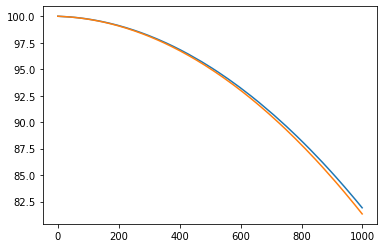

In [89]:
import matplotlib.pyplot as plt
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])

In [90]:
res = model.evaluate(X_test, y_test, verbose=0)

print(f'MAPE on the test set : {res[1]:.0f} %')

MAPE on the test set : 82 %


In [91]:
res

[36219277312.0, 81.8615951538086]

In [92]:
model.evaluate(X_test, y_test, verbose=0)

[36219277312.0, 81.8615951538086]

In [93]:
y_test.shape

(40,)

In [94]:
#model.predict(X_test)

In [95]:
#X_test

In [96]:
#plt.plot(X_test,y_test)

# Empiler les couches RNN

In [45]:
def init_model_2():
    metric = metrics.MAPE
    opt = optimizers.RMSprop(learning_rate=0.005)
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(20, return_sequences=True, activation='tanh'))
    #model.add(layers.LSTM(20, return_sequences=True, activation='tanh')) # Ajout
    model.add(layers.LSTM(10, activation='tanh'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(loss='mse', 
                  optimizer=opt, 
                  metrics=[metric])
    
    return model

In [46]:
es = EarlyStopping(monitor='val_loss', verbose=1, patience=5, restore_best_weights=True)

model_2 = init_model_2()


history_2 = model_2.fit(X_train, y_train,
            validation_split=0.3,
            epochs=100, 
            batch_size=32,
            callbacks=[es], verbose=0)

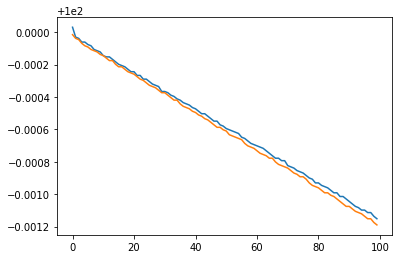

In [47]:
import matplotlib.pyplot as plt
plt.plot(history_2.history['mean_absolute_percentage_error'])
plt.plot(history_2.history['val_mean_absolute_percentage_error'])

In [48]:
res = model_2.evaluate(X_test, y_test, verbose=1)

print(f'MAPE on the test set : {res[1]:.0f} %')

2/2 [==============================] - 0s 2ms/step - loss: 50461179904.0000 - mean_absolute_percentage_error: 99.9988
MAPE on the test set : 100 %


# "grid search"

In [49]:
n_sequences = 200
length_x_min = 10
length_x_max = 50
ecart_min = 0
ecart_max = 10
length_min = 1
lenght_max = 10
pourcent_test = [0.6,0.65,0.7]

In [50]:
length_x

NameError: name 'length_x' is not defined

# test

In [ ]:
model
#model.predict(X_test)

In [ ]:
model = models.Sequential()
model.add(layers.LSTM(10, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1))
model.compile(loss='mse', optimizer='adam')

history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

In [ ]:
model.predict(X_test)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(model.history['val_mean_absolute_percentage_error'])

# test lstm kaggle: https://www.kaggle.com/code/charel/learn-by-example-rnn-lstm-gru-time-series/notebook

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [ ]:
model = models.Sequential()
model.add(layers.LSTM(50, return_sequences=True))
# , input_shape=(feature_train.shape[1],1)
#model.add(Dropout(0.2))
          
model.add(layers.LSTM(100, return_sequences=False))
#model.add(Dropout(0.2))
model.add(layers.Dense(1, activation = "linear"))

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

In [ ]:
model.predict(X_test)

In [ ]:
X_test